#### In this Homework 3, we will be using a public data set called Air Passenger which recorded the number of passenger 
#### every year from 1949 to 1960. We will apply various techniques to the data set in order to obtain
#### a good SARIMA model that we will be used for forecasting. The accuracy of model will be tested using RMSE. 
#### the references used for this excerce is at the bottom

In [36]:
import pandas as pd
import numpy as np
from scipy.stats import norm
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pylab as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.dpi']= 80
sns.set_style("whitegrid")
sns.set_context("poster")
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error


## 1.Descriptive Statistics

In [12]:
#load the dataset into pandas dataframe
mydate = lambda dates: pd.datetime.strptime(dates,'%Y-%m')
data =pd.read_csv('AirPassengers.csv',parse_dates=['Month'],index_col='Month',date_parser=mydate)
data = data.rename(columns={'#Passengers': 'NumberPassenger'})


In [13]:
# check the first 5 elements 
data.head()

,NumberPassenger
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [14]:
# check the last 5 elements 
data.tail()

,NumberPassenger
Month,
1960-08-01,606
1960-09-01,508
1960-10-01,461
1960-11-01,390
1960-12-01,432


In [15]:
# check out some descriptive statistics
data.describe()

,NumberPassenger
count,144.000000
mean,280.298611
std,119.966317
min,104.000000
25%,180.000000
50%,265.500000
75%,360.500000
max,622.000000


In [16]:
# check the variance
data.var()

NumberPassenger    14391.917201
dtype: float64

In [17]:
# check the data type of the dataset
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 144 entries, 1949-01-01 to 1960-12-01
Data columns (total 1 columns):
NumberPassenger    144 non-null int64
dtypes: int64(1)
memory usage: 2.2 KB


## 2.Visualization

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x00000288E8884828>]],
      dtype=object)

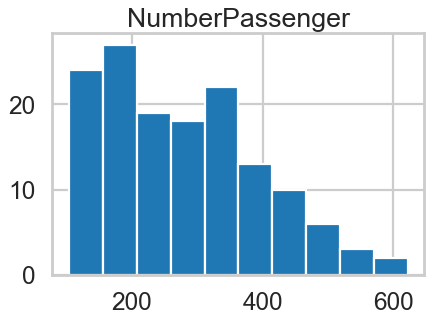

In [18]:
# check the histogram
data.hist()

In [19]:
# we will consider the column Month as index of the dataset
data.index

DatetimeIndex(['1949-01-01', '1949-02-01', '1949-03-01', '1949-04-01',
               '1949-05-01', '1949-06-01', '1949-07-01', '1949-08-01',
               '1949-09-01', '1949-10-01',
               ...
               '1960-03-01', '1960-04-01', '1960-05-01', '1960-06-01',
               '1960-07-01', '1960-08-01', '1960-09-01', '1960-10-01',
               '1960-11-01', '1960-12-01'],
              dtype='datetime64[ns]', name='Month', length=144, freq=None)

### A time series is stationary if the mean and the variance remain constant over time


Text(0, 0.5, 'Number of passengers')

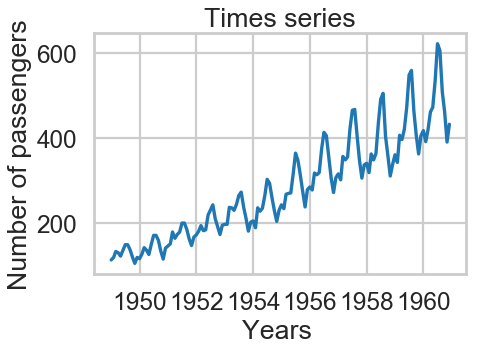

In [20]:
plt.plot(data)   ## plot the data to see if there is a trend or seasonal
plt.title("Times series")
plt.xlabel("Years ")
plt.ylabel("Number of passengers")


### By looking the output,  it is very clear there is an overall increasing  trend 

### We will split the data into 70% training and 30% testing

In [21]:
trainigPercent =0.70   ## percentage of the training set
splitdata=round(len(data)*trainigPercent)
training, testing=data[0:splitdata],data[splitdata:]  ## we split into training and testing set


## 3.Eliminating trend 


#### We have a multiplicative seasonality, so we  will apply a log filter and then analyze the residuals with autocorrelation plots.

Text(0, 0.5, 'Passengers')

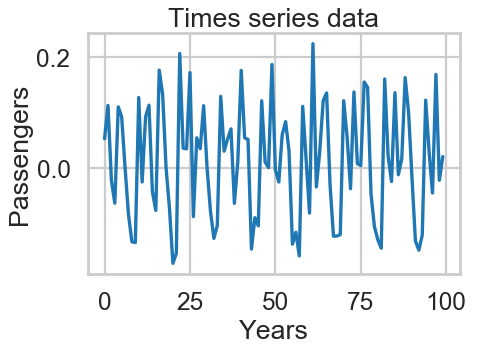

In [22]:
# data is multiplicative we apply log to transform
training =np.log(training)
# since we have positive linear trend we apply differencing of 1 period
training_diff =training.diff(periods=1).values[1:]

# we plot the residual difference
plt.plot(training_diff)
plt.title("Times series data")
plt.xlabel("Years")
plt.ylabel("Passengers")

#### We see here that there is no more a multiplicative affect and no more trend. 
#### It indicates that we need to remove the seasonal pattern which can be done with SARIMA.
##### We can select the seasonal pattern parameters of SARIMA by looking at the ACF and PACF plots.
###### Autocorrelation function(ACF) and Partial autocorrelation function(PACF)

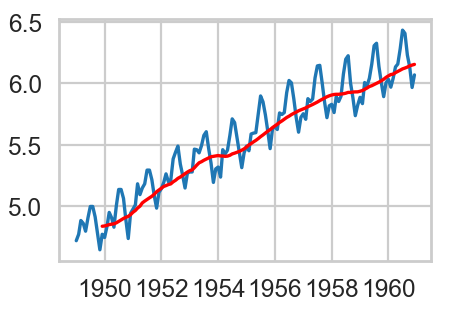

In [23]:
data_log=np.log(data)
moving_avg = data_log.rolling(12).mean()
plt.plot(data_log)
plt.plot(moving_avg, color='red')

Text(0, 0.5, 'ACF')

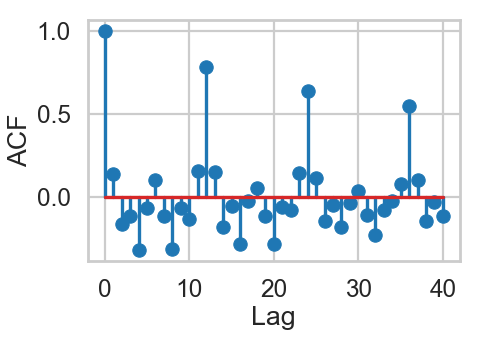

In [24]:
#import auto correlation and partial autocorrelation function
from statsmodels.tsa.stattools import acf,pacf
log_acf=acf(training_diff,nlags=40)
log_pacf=pacf(training_diff,nlags=40,method='ols')

#plot ACF
plt.stem(log_acf)
plt.xlabel("Lag")
plt.ylabel("ACF")



Text(0, 0.5, 'PACF')

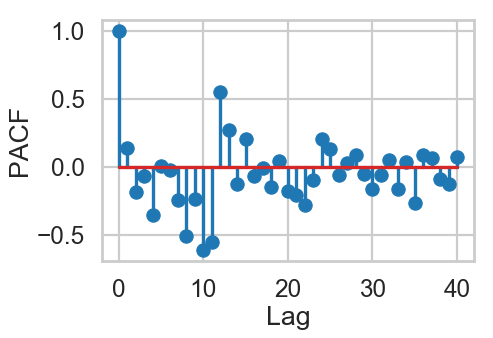

In [25]:
#plot ACF
plt.stem(log_pacf)
plt.xlabel("Lag")
plt.ylabel("PACF")


# 4.Quick rappel of the SARIMA Model is in the form (p,d,q) (P,D,Q)S


### Looking at the ACF and PACF plots we see our first significant value at lag 4 for ACF 
### At the same lag 4 for the PACF which suggest to use p = 4 and q = 4.
### We also have a big value at lag 12 in the ACF plot which suggests our season is S = 12 and 
### since this lag is positive it suggests P = 1 and Q = 0.
### Since this is a differenced series for SARIMA we set d = 1
### since the seasonal pattern is not stable over time we set D = 0. 
### All together this gives us a SARIMA(4,1,4)(1,0,0)[12] model.

## SARIMA(4,1,4)(1,0,0)[12] model, we will run and fit a model on our training data.

In [26]:
# we create the SARIAMX model object
model=SARIMAX(training,order=(4,1,4),seasonal_order=(1,0,0,12),enforce_stationarity=False,enforce_invertibility=False)
## Fit the model
model_fit =model.fit(disp=False)  

c:\users\diall\appdata\local\programs\python\python37\lib\site-packages\statsmodels\tsa\base\tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
c:\users\diall\appdata\local\programs\python\python37\lib\site-packages\statsmodels\base\model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


# 5.Forecasting processing

In [27]:
R =len(testing)        #number of furture steps times we want to forecast
forecast=model_fit.forecast(R) # forcast for k times
forecast=np.exp(forecast) # return to the origin without the log
predictions =model_fit.predict()

# 6.Display forcasting result

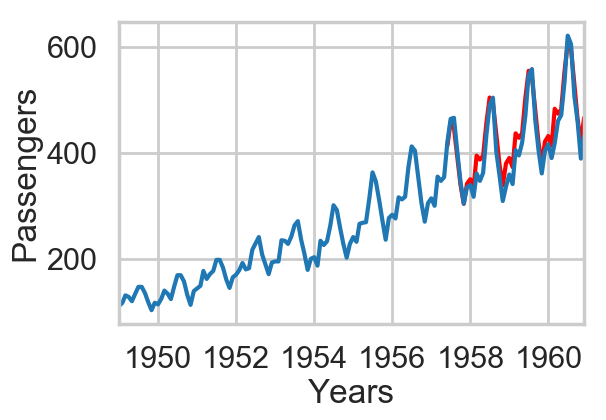

In [172]:
plt.plot(forecast,'r')
plt.plot(data)
plt.xlabel("Years")
plt.ylabel("Passengers")
plt.autoscale(enable=True,axis='x',tight=True)

### Test accuracy with Root Mean Square Error (RMSE)

In [37]:
ms =mean_squared_error(testing,forecast)
rmse =np.sqrt(ms)
print(rmse)

24.378405408785316


## the RMSE is 24.37 which is low that indicates the model fits the data very well

## The output shows that the model fit well the data 

In [173]:
# we will print the summary of the model
print(model_fit.summary())

                                 Statespace Model Results                                 
Dep. Variable:                        #Passengers   No. Observations:                  101
Model:             SARIMAX(4, 1, 4)x(1, 0, 0, 12)   Log Likelihood                 144.138
Date:                            Mon, 25 Feb 2019   AIC                           -268.275
Time:                                    20:52:20   BIC                           -243.967
Sample:                                01-01-1949   HQIC                          -258.504
                                     - 05-01-1957                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.1331      1.091      0.122      0.903      -2.005       2.271
ar.L2         -0.5250      0.283   

## References
### http://www.blackarbs.com/blog/time-series-analysis-in-python-linear-models-to-garch/11/1/2016
### https://www.datasciencecentral.com/profiles/blogs/tutorial-forecasting-with-seasonal-arima
### https://www.digitalocean.com/community/tutorials/a-guide-to-time-series-visualization-with-python-3
### https://www.statsmodels.org/dev/examples/notebooks/generated/statespace_sarimax_stata.html